In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data_file = '../data/training_data/1992-1997_training_data.csv'
output_file_raw = '../data/training_data/1992-1997_training_data_raw.csv'
output_file_rolling_window = '../data/training_data/1992-1997_training_data_rolling_window.csv'
output_file_daily_mean = '../data/training_data/1992-1997_training_data_daily_mean.csv'

In [ ]:
# read data
data = pd.read_csv(data_file, low_memory=False)

# set ignition to 0 for noxels with no fire
data['ignition'].fillna(0, inplace=True)

# Count fires with known and unknow discovery time
total_fires = len(data[data["ignition"] == 1])
unknown_discovery_time = data['fire_discovery_time'].isnull().sum()
known_discovery_time = len(data) - unknown_discovery_time

# clean up raw data
data['weather_bin_time'] = pd.to_datetime(data['weather_bin_time'])
data['weather_bin_day'] = data['weather_bin_time'].dt.day
data['weather_bin_month'] = data['weather_bin_time'].dt.month
data['weather_bin_year'] = data['weather_bin_time'].dt.year
data.drop(['fire_discovery_time', 'size', 'size_class'], axis=1, inplace=True)
data.dropna(inplace=True)

# count number of observations in each class
ignition_count = len(data[data["ignition"] == 1])
no_ignition_count = len(data) - ignition_count
print('Total observations: {:.1E}'.format(len(data)))
print('Ignitions count: {:.1E}'.format(ignition_count))
print('Non ignitions count: {:.1E}'.format(no_ignition_count))

In [ ]:
data.head()

OK, so before we dig into this much farther, I am noticing an issue. We only have a discovery time for about ~1/3 of our fires.

In [ ]:
print("Total fires: {}".format(total_fires))
print("Fires with known discovery time: {}".format(known_discovery_time))

We do, however, have a discovery date for almost all of them. I can imagine a few ways of dealing with this:

1. Throw out fires for which we do not know the discovery time
2. Average everything at the day resolution level

I am leaning toward option two because:

1. Discovery time is not ignition time. Even when we know the discovery time, the fire may have been discovered hours after it started, therefore the weather state at the discovery time may be significantly different from the weather state at ignition.
2. The data is already skewed toward no ignition observations. I would rather not have to throw out even more fires. Doing so would also mean that there are more noxels in the dataset which should have been labeled fire but are instead labeled no fire.

Specific plan is to roll a daily moving average across the data, including ignition value. This will assign a nonzero ignition value to all noxels within 24 hr. of a fire's discovery. The benefit here is twofold:

1. Weather conditions will be smoothed over the time period in which the fire is likely to have started (24 hrs around the discovery day).
2. We are not inferring a specific ignition time from discovery day, we implicitly acknowledge that the fire might have started significantly before it was discovered - in this case up to 24 hrs before the day in which is was discovered.

**Note**: Reversing the order of the dataframe means we will not assign non negative ignition values after the discovery day, just before.

In [108]:
# read data
data_rolling_window = pd.read_csv(data_file, low_memory=False)

# set ignition to 0 for noxels with no fire
data_rolling_window['ignition'].fillna(0, inplace=True)

# roll data with 24 hr windowed mean
data_rolling_window = data_rolling_window.iloc[::-1]
data_rolling_window = data_rolling_window.groupby(['lat', 'lon']).rolling(12, on="weather_bin_time").mean()
data_rolling_window.reset_index(drop=True, inplace=True)

# clean up dataframe
data_rolling_window['weather_bin_time'] = pd.to_datetime(data_rolling_window['weather_bin_time'])
data_rolling_window['weather_bin_day'] = data_rolling_window['weather_bin_time'].dt.day
data_rolling_window['weather_bin_month'] = data_rolling_window['weather_bin_time'].dt.month
data_rolling_window['weather_bin_year'] = data_rolling_window['weather_bin_time'].dt.year
data_rolling_window.drop(['fire_discovery_time', 'size', 'size_class'], axis=1, inplace=True)
data_rolling_window.dropna(inplace=True)

ignitions = data_rolling_window[data_rolling_window['ignition'] > 0].copy()
no_ignitions = data_rolling_window[data_rolling_window['ignition'] == 0].copy()
ignitions['ignition'] = 1

data_rolling_window = ignitions.append(no_ignitions)

# count number of observations in each class
ignition_count = len(data_rolling_window[data_rolling_window["ignition"] == 1])
no_ignition_count = len(data_rolling_window) - ignition_count
print('Total observations: {:.1E}'.format(len(data_rolling_window)))
print('Ignitions count: {:.1E}'.format(ignition_count))
print('Non ignitions count: {:.1E}'.format(no_ignition_count))

Total observations: 7.3E+06
Ignitions count: 6.6E+05
Non ignitions count: 6.6E+06


Total number of ignition containing rows increased - this is expected, our rolling window would have assigned nonzero ignition values to before and after the recorded discovery date for each fire. Also as expected, the total size of the dataset remained constant. Before we move on, let's take a look and see if we changed the geospatial distribution of fires.

In [109]:
# First, subset by year and month so we are not dealing with too much data.
# Choose 1994 because it is in the middle of the dataset and July because
# it is peak fire season in California
raw_data_one_month_ignitions = data[
    (data['weather_bin_year'] == 1994) & 
    (data['weather_bin_month'] == 7) &
    (data['ignition'] == 1)
]

rolling_window_data_one_month_ignitions = data_rolling_window[
    (data_rolling_window['weather_bin_year'] == 1994) & 
    (data_rolling_window['weather_bin_month'] == 7) &
    (data_rolling_window['ignition'] == 1)
]

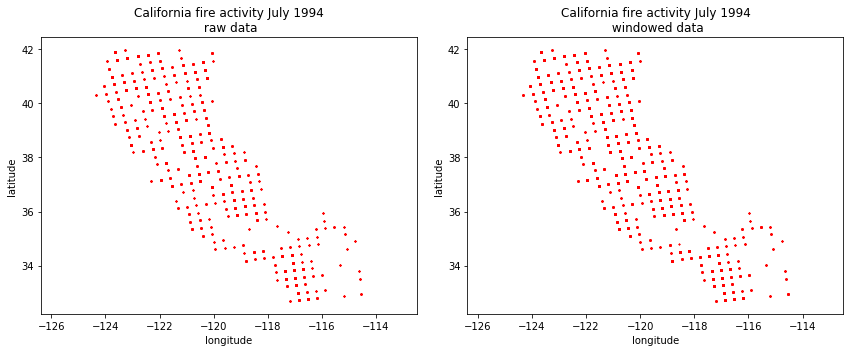

In [110]:
# Plot fire locations for raw and windowed data
plt.subplots(1,2,figsize=(12,5))

plt.subplot(1, 2, 1)
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(
    x=raw_data_one_month_ignitions['lon'], 
    y=raw_data_one_month_ignitions['lat'], 
    color='red', 
    s=0.5)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('California fire activity July 1994\n raw data')
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(
    x=rolling_window_data_one_month_ignitions['lon'], 
    y=rolling_window_data_one_month_ignitions['lat'], 
    color='red', 
    s=0.5)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('California fire activity July 1994\n windowed data')
plt.axis('equal')

plt.tight_layout()
plt.show()

Ok, at first glance, does not look like we deformed the data. Let's pull out a specific location during July of 1994 and take a look at how the weather variables compare over the course of the month.

In [111]:
raw_data_one_month_ignitions.head(1)

,weather_bin_time,lat,lon,air.sfc,air.2m,apcp,crain,rhum.2m,dpt.2m,pres.sfc,...,hcdc,mcdc,hpbl,prate,vis,ulwrf.sfc,ignition,weather_bin_day,weather_bin_month,weather_bin_year
3028204,1994-07-01,39.30418,-123.2773,304.77017,297.61868,0.0,0.0,50.092274,286.4488,95152.0,...,0.0,0.0,1186.5784,0.000003,20012.793,448.875,1.0,1,7,1994


The coordinates: 39.30418, -123.2773 had at least one fire, so let's start there:

In [112]:
raw_data_one_month = data[
    (data['weather_bin_year'] == 1994) & 
    (data['weather_bin_month'] == 7) &
    (data['lat'] == 39.30418) &
    (data['lon'] == -123.2773)
]

rolling_window_data_one_month = data_rolling_window[
    (data_rolling_window['weather_bin_year'] == 1994) & 
    (data_rolling_window['weather_bin_month'] == 7) &
    (np.isclose(data_rolling_window['lat'], 39.30418)) & # Some sort of float accuracy
    (np.isclose(data_rolling_window['lon'], -123.2773))  # funny busines going on here
]

In [113]:
# Sort data for plotting
raw_data_one_month = raw_data_one_month.sort_values(by='weather_bin_time',ascending=True)
rolling_window_data_one_month = rolling_window_data_one_month.sort_values(by='weather_bin_time',ascending=True)

# Add day number
raw_data_one_month.insert(0, 'hour', range(1, (len(raw_data_one_month) + 1)))
rolling_window_data_one_month.insert(0, 'hour', range(1, (len(rolling_window_data_one_month) + 1)))

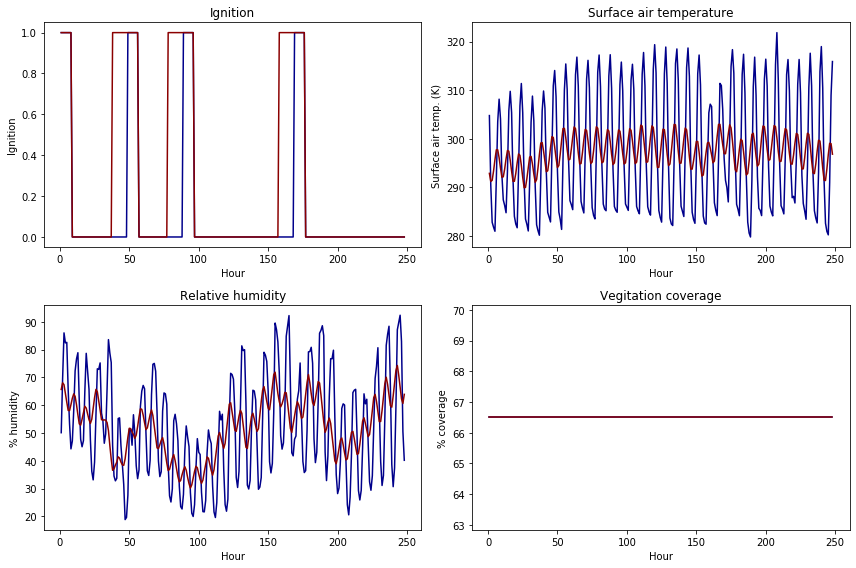

In [114]:
# Plot fires for raw and windowed data
plt.subplots(2,2,figsize=(12,8))

plt.subplot(2, 2, 1)
plt.plot(
    raw_data_one_month['hour'], 
    raw_data_one_month['ignition'],
    color = "darkblue",
    label ='Raw data'
)
plt.plot(
    rolling_window_data_one_month['hour'], 
    rolling_window_data_one_month['ignition'],
    color = "darkred",
    label ='Windowed data'
)
plt.xlabel('Hour')
plt.ylabel('Ignition')
plt.title('Ignition')

plt.subplot(2, 2, 2)
plt.plot(
    raw_data_one_month['hour'], 
    raw_data_one_month['air.sfc'],
    color = "darkblue",
    label ='Raw data',
)
plt.plot(
    rolling_window_data_one_month['hour'], 
    rolling_window_data_one_month['air.sfc'],
    color = "darkred",
    label ='Windowed data'
)
plt.xlabel('Hour')
plt.ylabel('Surface air temp. (K)')
plt.title('Surface air temperature')

plt.subplot(2, 2, 3)
plt.plot(
    raw_data_one_month['hour'], 
    raw_data_one_month['rhum.2m'],
    color = "darkblue",
    label ='Raw data'
)
plt.plot(
    rolling_window_data_one_month['hour'], 
    rolling_window_data_one_month['rhum.2m'],
    color = "darkred",
    label ='Windowed data'
)
plt.xlabel('Hour')
plt.ylabel('% humidity')
plt.title('Relative humidity')

plt.subplot(2, 2, 4)
plt.plot(
    raw_data_one_month['hour'], 
    raw_data_one_month['veg'],
    color = "darkblue",
    label ='Raw data'
)
plt.plot(
    rolling_window_data_one_month['hour'], 
    rolling_window_data_one_month['veg'],
    color = "darkred",
    label ='Windowed data'
)
plt.xlabel('Hour')
plt.ylabel('% coverage')
plt.title('Vegitation coverage')

plt.tight_layout()
plt.show()

In [107]:
data_daily_mean = data_rolling_window.groupby([
    'lat', 
    'lon', 
    'weather_bin_year',
    'weather_bin_month',
    'weather_bin_day'
]).mean().reset_index()

data_daily_mean.reset_index(drop=True, inplace=True)

ignitions = data_daily_mean[data_daily_mean['ignition'] > 0].copy()
no_ignitions = data_daily_mean[data_daily_mean['ignition'] == 0].copy()
ignitions['ignition'] = 1

data_daily_mean = ignitions.append(no_ignitions)

print('Total observations: {:.1E}'.format(len(data_daily_mean)))

Total observations: 9.0E+05


In [ ]:
data.to_csv(output_file_raw, index=False)

In [ ]:
data_rolling_window.to_csv(output_file_rolling_window, index=False)

In [ ]:
data_daily_mean.to_csv(output_file_daily_mean, index=False)